# Matching soft and hard potentials

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ June 26, 2023

This notebook looks at matching soft and hard potentials using unitary transformations.

_Last update:_ June 26, 2023

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.linalg as la

In [2]:
# Imports from scripts
from scripts.figures import (
    interpolate_matrix, label_kvnn, label_ticks, set_rc_parameters
)
from scripts.integration import unattach_weights_from_vector
from scripts.potentials import Potential
from scripts.srg import compute_srg_transformation
from scripts.wave_function import wave_function

## Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [4]:
# Momentum mesh
kmax, kmid, ntot = 15.0, 3.0, 120

# Partial wave channel
channel = '1S0'

# AV18
potential_av18 = Potential(6, channel, kmax, kmid, ntot)

# SMS N4LO 450 MeV
potential_chiral = Potential(111, channel, kmax, kmid, ntot)

## Functions

$$
\tilde{U} = \sum_\alpha
    \lvert \psi^{\rm{soft}}_\alpha \rangle
    \langle \psi^{\rm{hard}}_\alpha \rvert
$$

$$
U_\lambda = \sum_\alpha
    \lvert \psi_\alpha(\lambda) \rangle
    \langle \psi_\alpha(\infty) \rvert
$$

In [5]:
def U_tilde(H_soft, H_hard):
    """Unitary transformation relating soft and hard Hamiltonians."""
    
    Ntot = len(H_soft)

    # Get the eigenvectors of the hard and soft Hamiltonians
    _, vecs_hard = la.eigh(H_hard)
    _, vecs_soft = la.eigh(H_soft)

    # Initialize unitary transformation U with same size as Hamiltonians
    U_matrix = np.zeros((Ntot, Ntot))

    # Transformation is given by summing over the outer product of soft and
    # hard eigenvectors
    for alpha in range(Ntot):

        # Individual eigenvectors (these are already sorted correctly from 
        # numpy.linalg.eigh)
        psi_alpha_hard = vecs_hard[:, alpha]
        psi_alpha_soft = vecs_soft[:, alpha]

        # Make sure the phases match
        if psi_alpha_hard.T @ psi_alpha_soft < 0:
            psi_alpha_soft = -psi_alpha_soft

        # Outer product of eigenvectors
        U_matrix += np.outer(psi_alpha_soft, psi_alpha_hard)

    return U_matrix

In [6]:
def deuteron_binding_energy(H_matrix):
    """Print the deuteron binding energy of the 3S1-3D1 Hamiltonian."""
    
    eigenvalues, _ = la.eigh(H_matrix)
    
    print(f"Deuteron binding energy = {eigenvalues[0]:.5f} MeV.")

In [7]:
def compare_potentials(
    potential_soft, potential_hard, lambda_m, levels_number=61,
    colorbar_limits=(-1.0,1.0), color_map='turbo', axes_limits=(0.0,6.0),
    xlabel_size=16, ylabel_size=16
):
    
    # Get soft potential
    V_soft = potential_soft.load_potential()
    V_soft_MeV = potential_soft.convert_V_to_MeV(V_soft)  # Integration weights
    
    # Get momentum mesh
    k_array, _ = potential_soft.load_mesh()
    
    # Get initial soft Hamiltonian
    H_soft_initial = potential_soft.load_hamiltonian()
    
    # Get hard potential
    V_hard = potential_hard.load_potential()
    
    # Get initial and evolved hard Hamiltonian
    H_hard_initial = potential_hard.load_hamiltonian()
    H_hard_evolved = potential_hard.load_hamiltonian(
        method='srg',generator='Wegner', lamb=lambda_m
    )
    
    # Get hard SRG transformation
    U_hard_srg = compute_srg_transformation(H_hard_initial, H_hard_evolved)
    
    # Get unitary transformation relating the two potentials
    U_til = U_tilde(H_soft_initial, H_hard_initial)

    # --- Figure set-up --- #
    plt.close('all')
    col_number = 4
    f, axs = plt.subplots(1, col_number, sharex=True, sharey=True,
                          figsize=(4*col_number,4))
    
    # Set contour levels
    levels = np.linspace(colorbar_limits[0], colorbar_limits[1],
                         levels_number)
    
    # --- Get data --- #

    # Interpolate/plot up to this value
    k_max = axes_limits[1] + 0.2  # Add a little extra to prevent white edges

    for i in range(4):
        
        # Soft potential
        if i == 0:  
            
            V_matrix = V_soft
            label = label_kvnn(potential_soft.kvnn)
        
        # Hard potential
        elif i == 1:
            
            V_matrix = V_hard
            label = label_kvnn(potential_hard.kvnn)
        
        # Inverse-SRG transformed soft potential
        elif i == 2:
            
            V_MeV = U_hard_srg.T @ V_soft_MeV @ U_hard_srg
            V_matrix = potential_soft.convert_V_to_fm(V_MeV)
            label = (r"$U^{\dagger}_{\rm{hard}}(\lambda_m)$"
                     r"$V^{\phantom{\dagger}}_{\rm{soft}}$"
                     r"$U^{\phantom{\dagger}}_{\rm{hard}}(\lambda_m)$")

        # U_tilde transformed soft potential
        elif i == 3:
            
            V_MeV = U_til.T @ V_soft_MeV @ U_til
            V_matrix = potential_soft.convert_V_to_fm(V_MeV)
            label = r"$\tilde{U}^\dagger V_{\rm{soft}} \tilde{U}$"

        # Interpolate potential for high resolution contour figure
        k_array_dense, _, V_matrix_dense = interpolate_matrix(
            k_array, k_array, V_matrix[:120,:120], k_max, k_max)

        # --- Plot --- #
        c = axs[i].contourf(k_array_dense, k_array_dense, V_matrix_dense,
                            levels, cmap=color_map, extend='both')

        # --- Axes limits --- #
        axs[i].set_xlim(axes_limits)
        axs[i].set_ylim(axes_limits)

        # --- Axes labels --- #
        # x-axis
        axs[i].set_xlabel("$k'$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
            
        # y-axis
        if i == 0:  # Label y-axis of far-left sub-plot only
            axs[i].set_ylabel("$k$ [fm" + r"$^{-1}$" + "]",
                              fontsize=ylabel_size)
    
        # --- Adjust axes --- #
        # Switch x-axis label from bottom to top
        axs[i].xaxis.set_label_position('top')
        axs[i].tick_params(labeltop=True, labelbottom=False)
        # Invert y-axis
        axs[i].invert_yaxis()
        
        # --- Additional labels --- #
        axs[i].add_artist(
            AnchoredText(label, loc='lower left', prop=dict(size=17)))
        if i == 2:
            lambda_m_label = rf"$\lambda_m = {lambda_m}$" + " fm$^{-1}$"
            axs[i].add_artist(
                AnchoredText(lambda_m_label, loc='upper right',
                             prop=dict(size=17))
            )
            
    # Amount of white space in-between sub-plots
    f.subplots_adjust(wspace=0.05)
    
    # --- Colorbar --- #
    # Colorbar location (left, bottom, width, height)
    cbar_ax = f.add_axes((0.9+0.1/col_number, 0.15, 0.1/col_number, 0.7))
    # Set colorbar ticks and tick labels
    levels_ticks = np.linspace(colorbar_limits[0], colorbar_limits[1], 9)
    levels_ticks_strings = label_ticks(levels_ticks)  # Make these strings
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.set_yticklabels(levels_ticks_strings)
    cbar.ax.set_title("[fm]", fontsize=16, pad=15)

    plt.show()

In [17]:
def compare_deuteron_wfs(
        kvnn_soft, kvnn_hard, lambda_m, x_limits=(0.0,6.0),
        y_limits=(1e-6,1e3), xlabel_size=16, ylabel_size=16
):
    """Deuteron wavefunctions of soft, hard, and transformed potentials."""
    
    # Channel is 3S1-3D1 for deuteron
    channel = '3S1'
    kmax, kmid, ntot = 15.0, 3.0, 120
    
    # Hard potential
    potential_hard = Potential(kvnn_hard, channel, kmax, kmid, ntot)

    # Soft potential
    potential_soft = Potential(kvnn_soft, channel, kmax, kmid, ntot)
    
    # The momentum mesh should be the same between both potentials
    q_array, q_weights = potential_soft.load_mesh()
    
    # Get initial Hamiltonians
    H_soft_initial = potential_soft.load_hamiltonian()
    H_hard_initial = potential_hard.load_hamiltonian()
    H_hard_evolved = potential_hard.load_hamiltonian(
        method='srg', generator='Wegner', lamb=lambda_m)
    
    
    # Get hard SRG transformation
    U_hard_srg = compute_srg_transformation(H_hard_initial, H_hard_evolved)
    
    # Get unitary transformation relating the two potentials
    U_til = U_tilde(H_soft_initial, H_hard_initial)
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    for i in range(4):
        
        # Soft potential
        if i == 0:  
            
            psi_d_weights = wave_function(H_soft_initial)
            psi_d = unattach_weights_from_vector(
                q_array, q_weights, psi_d_weights, coupled_channel=True
            )
            n_d_array = psi_d[:ntot] ** 2 + psi_d[ntot:] ** 2
            
            ax.semilogy(q_array, n_d_array, label=label_kvnn(kvnn_soft),
                        linestyle='solid', linewidth=2.0)
            
            deuteron_binding_energy(H_soft_initial)

        # Hard potential
        elif i == 1:
            
            psi_d_weights = wave_function(H_hard_initial)
            psi_d = unattach_weights_from_vector(
                q_array, q_weights, psi_d_weights, coupled_channel=True
            )
            n_d_array = psi_d[:ntot] ** 2 + psi_d[ntot:] ** 2
            
            ax.semilogy(q_array, n_d_array, label=label_kvnn(kvnn_hard),
                        linestyle='solid', linewidth=2.0)
            
            deuteron_binding_energy(H_hard_initial)
        
        # Inverse-SRG transformed soft potential
        elif i == 2:
            
            H_matrix = U_hard_srg.T @ H_soft_initial @ U_hard_srg
            
            psi_d_weights = wave_function(H_matrix)
            psi_d = unattach_weights_from_vector(
                q_array, q_weights, psi_d_weights, coupled_channel=True
            )
            n_d_array = psi_d[:ntot] ** 2 + psi_d[ntot:] ** 2

            hamiltonian_label = (
                r"$U^{\dagger}_{\rm{hard}}(\lambda_m)$"
                r"$H^{\phantom{\dagger}}_{\rm{soft}}$"
                r"$U^{\phantom{\dagger}}_{\rm{hard}}(\lambda_m)$"
            )
            
            ax.semilogy(q_array, n_d_array, label=hamiltonian_label,
                        linestyle='dashed', linewidth=2.0)
            
            deuteron_binding_energy(H_matrix)

        # U_tilde transformed soft potential
        elif i == 3:
            
            H_matrix = U_til.T @ H_soft_initial @ U_til
            
            psi_d_weights = wave_function(H_matrix)
            psi_d = unattach_weights_from_vector(
                q_array, q_weights, psi_d_weights, coupled_channel=True
            )
            n_d_array = psi_d[:ntot] ** 2 + psi_d[ntot:] ** 2

            hamiltonian_label = r"$\tilde{U}^\dagger H_{\rm{soft}} \tilde{U}$"
            
            ax.semilogy(q_array, n_d_array, label=hamiltonian_label,
                        linestyle='dashed', linewidth=2.0)
            
            deuteron_binding_energy(H_matrix)

    # --- Axes limits --- #
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    
    # --- Legend --- #
    ax.legend(loc='upper right', fontsize=11, frameon=False)
    
    # --- Set title --- #
    ax.set_title(rf"$\lambda_m = {lambda_m}$" + " fm$^{-1}$", fontsize=16)

    # --- Axes labels --- #
    ax.set_xlabel("$q$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    ax.set_ylabel("$|\psi_d(q)|^2$ [fm" + r"$^3$" + "]", fontsize=ylabel_size)

    plt.show()

## Compare potential matrix elements

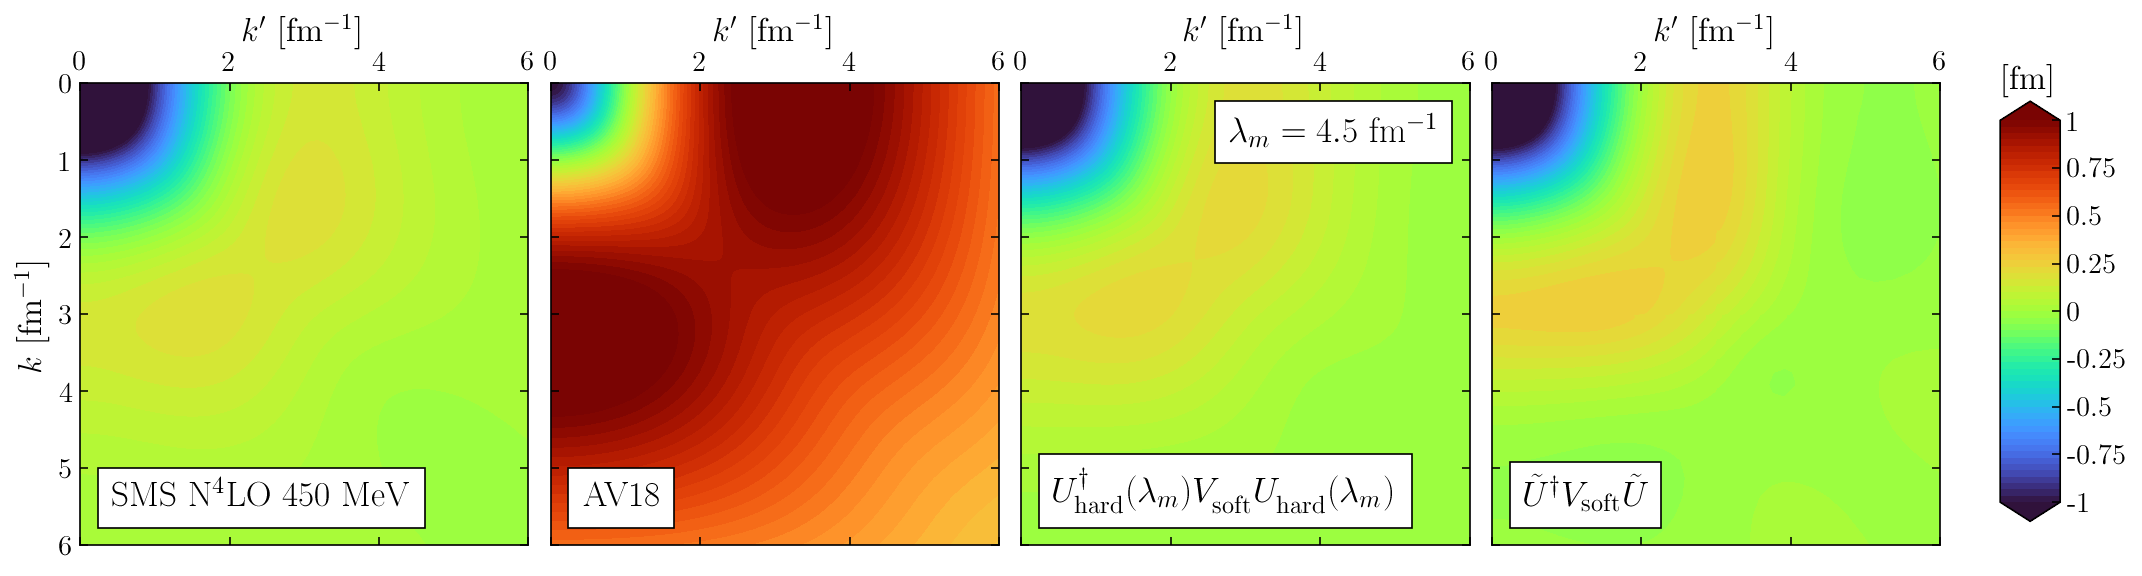

In [9]:
# \lambda_m = 4.5 in 1S0 channel
compare_potentials(potential_chiral, potential_av18, 4.5)

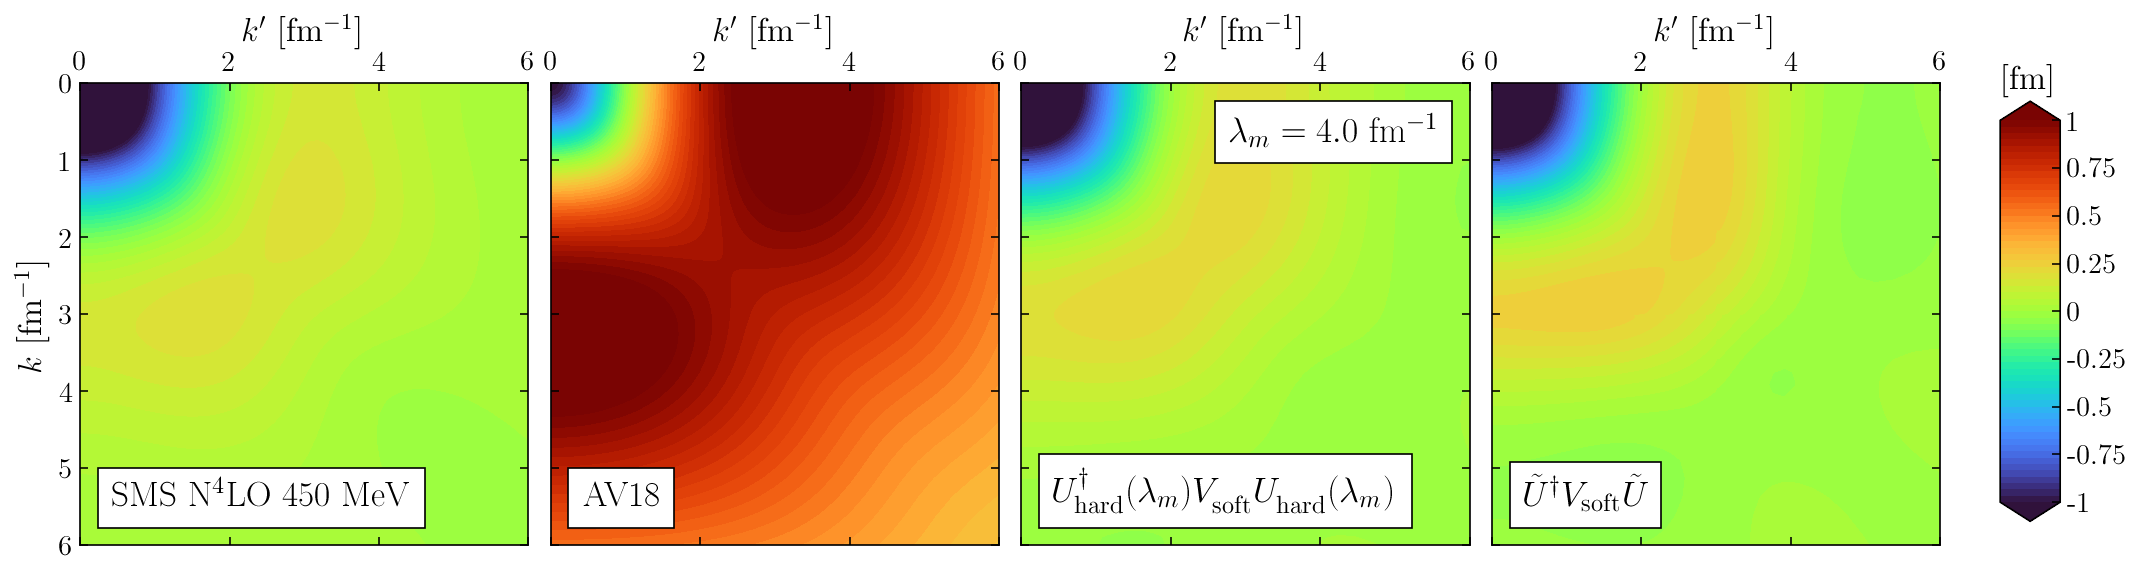

In [10]:
# \lambda_m = 4 in 1S0 channel
compare_potentials(potential_chiral, potential_av18, 4.0)

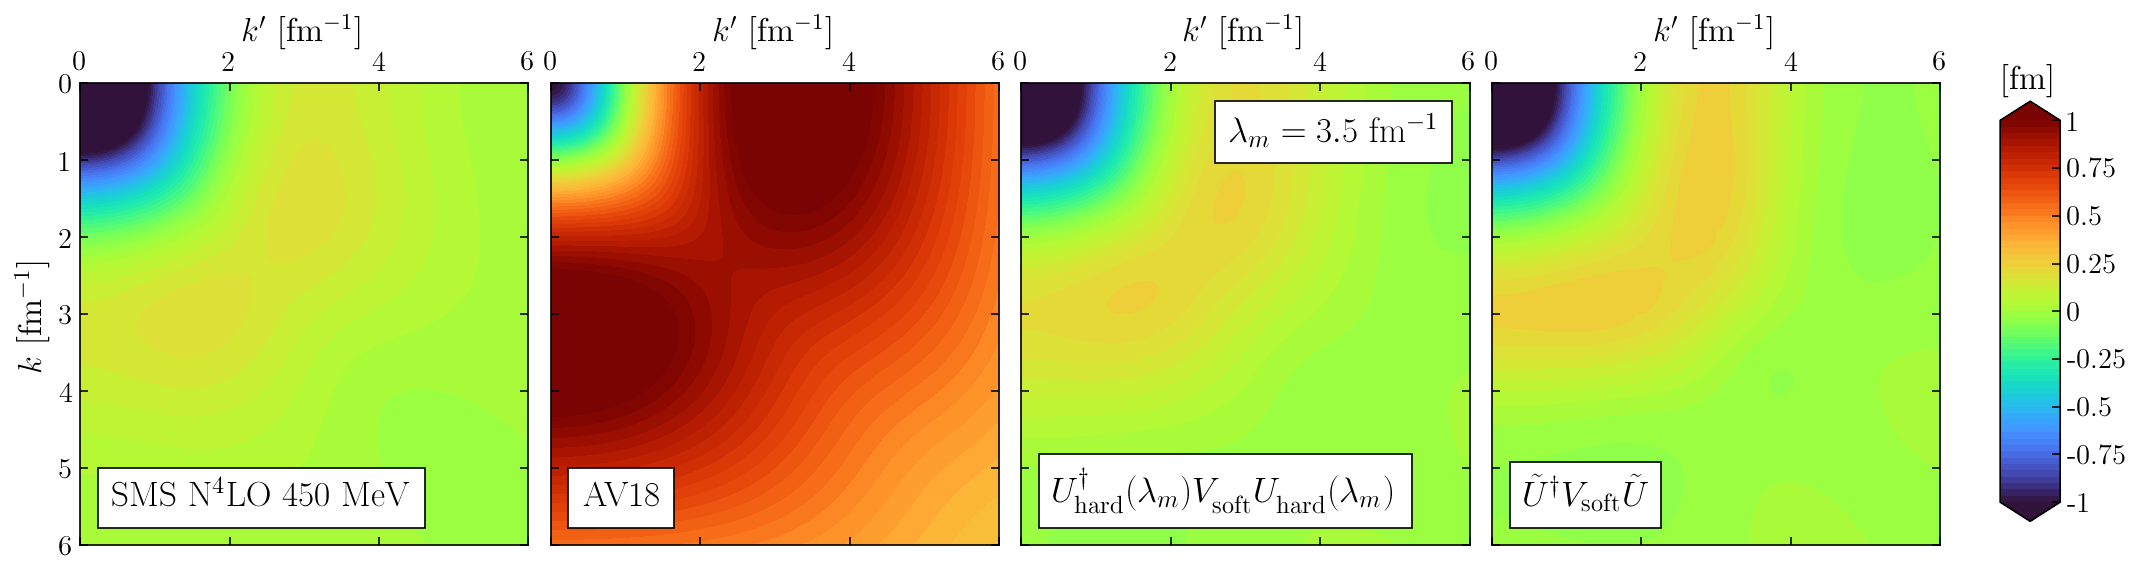

In [11]:
# \lambda_m = 3.5 in 1S0 channel
compare_potentials(potential_chiral, potential_av18, 3.5)

## Compare deuteron wave function

Deuteron binding energy = -2.22321 MeV.
Deuteron binding energy = -2.22450 MeV.
Deuteron binding energy = -2.22321 MeV.
Deuteron binding energy = -2.22321 MeV.


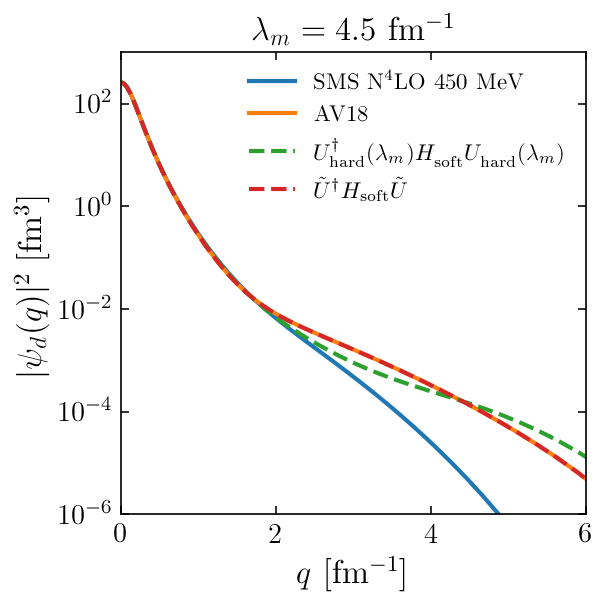

In [18]:
compare_deuteron_wfs(111, 6, 4.5)

Deuteron binding energy = -2.22321 MeV.
Deuteron binding energy = -2.22450 MeV.
Deuteron binding energy = -2.22321 MeV.
Deuteron binding energy = -2.22321 MeV.


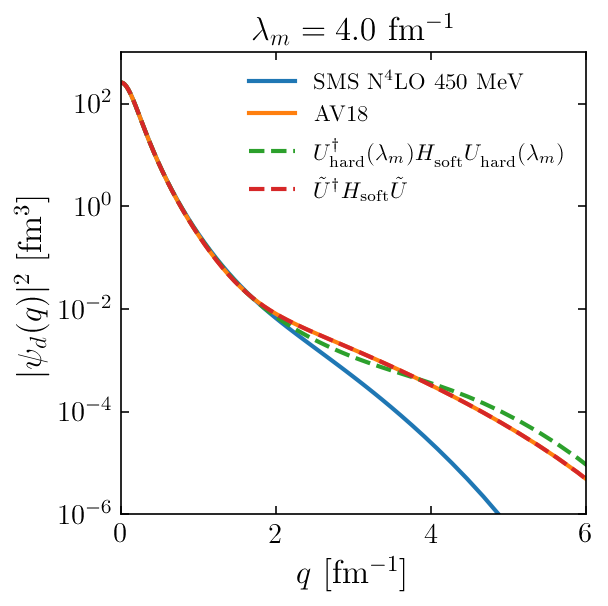

In [19]:
compare_deuteron_wfs(111, 6, 4.0)

Deuteron binding energy = -2.22321 MeV.
Deuteron binding energy = -2.22450 MeV.
Deuteron binding energy = -2.22321 MeV.
Deuteron binding energy = -2.22321 MeV.


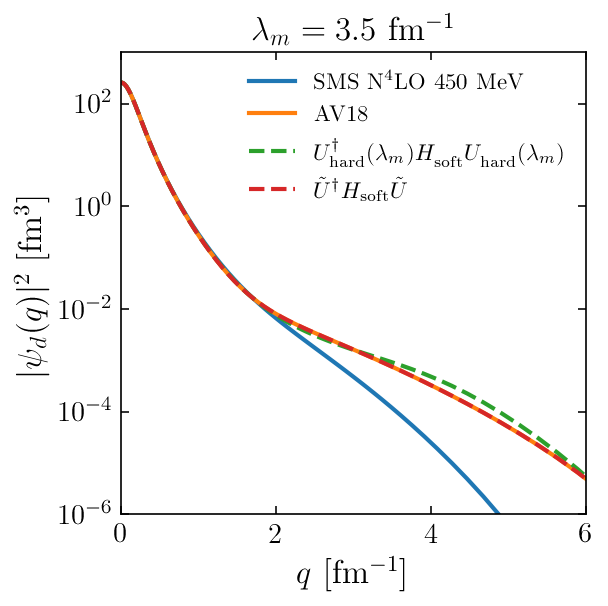

In [20]:
compare_deuteron_wfs(111, 6, 3.5)